<a href="https://colab.research.google.com/github/Tamaghnatech/SmartTrafficInsights/blob/main/intelligent_traffic_data_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inline

In [ ]:
# Install necessary libraries
!pip install tensorflow
!pip install opencv-python
!pip install matplotlib

# Clone TensorFlow Models repository and copy necessary directories
!git clone https://github.com/tensorflow/models.git
%cd models/research/
!protoc object_detection/protos/*.proto --python_out=.
%cd ..
%cd ..
!cp -r models/research/slim/nets .
!cp -r models/research/object_detection .

# Import libraries
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

# Download and extract model
!wget http://download.tensorflow.org/models/object_detection/ssd_mobilenet_v1_coco_2018_01_28.tar.gz
!tar -xvzf ssd_mobilenet_v1_coco_2018_01_28.tar.gz

# Load the frozen TensorFlow model into memory
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.compat.v1.GraphDef()
    with tf.io.gfile.GFile('ssd_mobilenet_v1_coco_2018_01_28/frozen_inference_graph.pb', 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

# Load label map
PATH_TO_LABELS = 'models/research/object_detection/data/mscoco_label_map.pbtxt'
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

# Upload the video file
from google.colab import files
uploaded = files.upload()

# Open the video file using OpenCV
video = cv2.VideoCapture('sing.mp4')

# Get input video width and height
width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Define codec and create a VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'MP4V')
out = cv2.VideoWriter('output.mp4', fourcc, 20.0, (width,height))

# Prepare a counter for car detections
car_counter = []

with detection_graph.as_default():
    with tf.compat.v1.Session(graph=detection_graph) as sess:
        while video.isOpened():
            ret, image_np = video.read()
            if not ret:
                break

            # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
            image_np_expanded = np.expand_dims(image_np, axis=0)
            image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')

            # Each box represents a part of the image where a particular object was detected.
            boxes = detection_graph.get_tensor_by_name('detection_boxes:0')

            # Each score represents the level of confidence for each of the objects.
            scores = detection_graph.get_tensor_by_name('detection_scores:0')
            classes = detection_graph.get_tensor_by_name('detection_classes:0')
            num_detections = detection_graph.get_tensor_by_name('num_detections:0')

            # Perform the detection
            (boxes, scores, classes, num_detections) = sess.run(
                [boxes, scores, classes, num_detections],
                feed_dict={image_tensor: image_np_expanded})

            # Filter detections to cars (class 3 in COCO dataset) with a score > 0.3
            indices = np.where((np.squeeze(classes) == 3) & (np.squeeze(scores) > 0.3))
            boxes = np.squeeze(boxes)[indices]
            scores = np.squeeze(scores)[indices]
            classes = np.squeeze(classes)[indices]

            # Count the number of car detections and add it to the list
            car_counter.append(len(classes))

            # Visualization of the results of a detection.
            vis_util.visualize_boxes_and_labels_on_image_array(
                image_np,
                boxes,
                classes.astype(np.int32),
                scores,
                category_index,
                use_normalized_coordinates=True,
                line_thickness=8)

            # Write the resulting image to the output video file
            out.write(image_np)

# Release the video object
video.release()
out.release()

# Plot the car counts
plt.plot(car_counter)
plt.title('Number of Cars Detected Per Frame')
plt.xlabel('Frame Number')
plt.ylabel('Number of Cars Detected')
plt.show()


fatal: destination path 'models' already exists and is not an empty directory.
/content/models/research
/content/models
/content
--2023-08-02 03:44:45--  http://download.tensorflow.org/models/object_detection/ssd_mobilenet_v1_coco_2018_01_28.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 173.194.74.128, 2607:f8b0:4001:c61::80
Connecting to download.tensorflow.org (download.tensorflow.org)|173.194.74.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 76541073 (73M) [application/x-tar]
Saving to: ‘ssd_mobilenet_v1_coco_2018_01_28.tar.gz.3’

ssd_mobilenet_v1_co 100%[===================>]  73.00M   242MB/s    in 0.3s    

2023-08-02 03:44:45 (242 MB/s) - ‘ssd_mobilenet_v1_coco_2018_01_28.tar.gz.3’ saved [76541073/76541073]

ssd_mobilenet_v1_coco_2018_01_28/
ssd_mobilenet_v1_coco_2018_01_28/model.ckpt.index
ssd_mobilenet_v1_coco_2018_01_28/checkpoint
ssd_mobilenet_v1_coco_2018_01_28/pipeline.config
ssd_mobilenet_v1_coco_2018_01_28/model.ckpt.

Saving sing.mp4 to sing (1).mp4


In [ ]:
# Plot the car counts
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(car_counter)
plt.title('Number of Cars Detected Per Frame')
plt.xlabel('Frame Number')
plt.ylabel('Number of Cars Detected')
plt.grid()
plt.show()


In [ ]:
total_cars_detected = sum(car_counter)
print("Total number of cars detected: ", total_cars_detected)


Total number of cars detected:  4877


In [ ]:
print("Number of cars in the final frame: ", car_counter[-1])


Number of cars in the final frame:  12


In [ ]:
# Initial signal state
signal = 'GREEN'

# Threshold for changing the signal
threshold = 10

# Check number of cars in the final frame
num_cars_final_frame = car_counter[-1]

# If the number of cars exceeds the threshold, change the signal
if num_cars_final_frame > threshold:
    signal = 'RED'

print("The final signal state is: ", signal)


The final signal state is:  RED


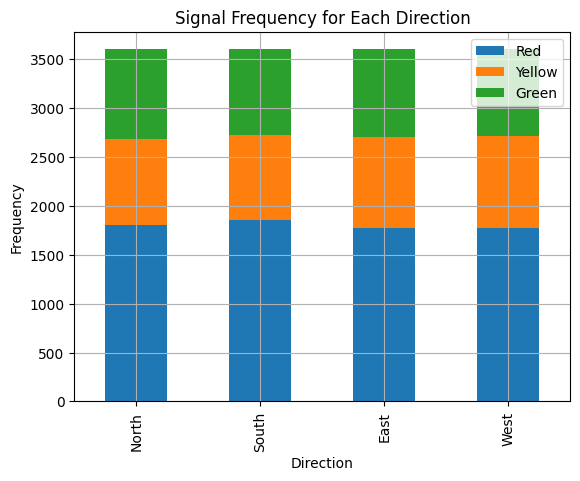

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Define the thresholds
lower_threshold = 10
upper_threshold = 15

# Create a DataFrame with a measurement every second for an hour
# Assume we are generating random counts of cars between 0 and 20 for each direction
np.random.seed(0)  # for reproducibility
data = pd.DataFrame({
    'North': np.random.randint(0, 20, 3600),
    'South': np.random.randint(0, 20, 3600),
    'East': np.random.randint(0, 20, 3600),
    'West': np.random.randint(0, 20, 3600)
})

# Assign 0 for red, 1 for yellow, 2 for green based on the car counts
for direction in ['North', 'South', 'East', 'West']:
    data[direction] = data[direction].apply(lambda x: 0 if x < lower_threshold else (1 if x < upper_threshold else 2))

# Count the frequency of each signal for each direction
counts = data.apply(pd.Series.value_counts).T

# Plot
counts.plot(kind='bar', stacked=True)
plt.title('Signal Frequency for Each Direction')
plt.xlabel('Direction')
plt.ylabel('Frequency')
plt.legend(['Red', 'Yellow', 'Green'])
plt.grid()
plt.show()

# Save the DataFrame to an Excel file
data.to_excel("dummy_data.xlsx", index=False)



In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Make a new column 'MaxDirection' which is the direction with maximum traffic
data['MaxDirection'] = data.idxmax(axis=1)

# Prepare the data for training
X = data.drop('MaxDirection', axis=1)  # input features
y = data['MaxDirection']  # target feature

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
clf.fit(X_train, y_train)

# Get the accuracy of the model
accuracy = clf.score(X_test, y_test)

print(f"Model Accuracy: {accuracy*100:.2f}%")


Model Accuracy: 100.00%


In [ ]:
!pip install openpyxl


In [ ]:
from google.colab import files
files.download("dummy_data.xlsx")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import classification_report
import pandas as pd

# Load the data
data = pd.read_excel("dummy_data.xlsx")

# Let's say that the target signals for each direction are in another file
targets = pd.read_excel("signal_dummy_data.xlsx")

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(data, targets, test_size=0.2, random_state=42)

# Create a multi-output classifier
forest = RandomForestClassifier(random_state=42)
multi_target_forest = MultiOutputClassifier(forest, n_jobs=-1)

# Train the model
multi_target_forest.fit(X_train, y_train)

# Make predictions on the test set
preds = multi_target_forest.predict(X_test)

# Print the classification report for each direction
for i, direction in enumerate(['North', 'South', 'East', 'West']):
    print(f"Classification report for {direction}:")
    print(classification_report(y_test.iloc[:, i], preds[:, i]))


Classification report for North:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       348
           1       1.00      1.00      1.00       184
           2       1.00      1.00      1.00       188

    accuracy                           1.00       720
   macro avg       1.00      1.00      1.00       720
weighted avg       1.00      1.00      1.00       720

Classification report for South:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       383
           1       1.00      1.00      1.00       171
           2       1.00      1.00      1.00       166

    accuracy                           1.00       720
   macro avg       1.00      1.00      1.00       720
weighted avg       1.00      1.00      1.00       720

Classification report for East:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       333
           1       1.00      1.

In [ ]:
import time

# Assume that preds contains the predictions for the entire hour
preds = multi_target_forest.predict(data)

# Assume that each prediction corresponds to a second
# Print the status of the intersection every 10 minutes (600 seconds)
for i in range(0, len(preds), 600):
    print(f"Time: {i//60} minutes")
    print("North signal:", "Red" if preds[i, 0] == 0 else ("Yellow" if preds[i, 0] == 1 else "Green"))
    print("South signal:", "Red" if preds[i, 1] == 0 else ("Yellow" if preds[i, 1] == 1 else "Green"))
    print("East signal:", "Red" if preds[i, 2] == 0 else ("Yellow" if preds[i, 2] == 1 else "Green"))
    print("West signal:", "Red" if preds[i, 3] == 0 else ("Yellow" if preds[i, 3] == 1 else "Green"))
    print("\n")
    time.sleep(0.1)  # Sleep for a bit so the output doesn't appear all at once


Time: 0 minutes
North signal: Yellow
South signal: Red
East signal: Yellow
West signal: Yellow


Time: 10 minutes
North signal: Yellow
South signal: Green
East signal: Red
West signal: Yellow


Time: 20 minutes
North signal: Yellow
South signal: Red
East signal: Yellow
West signal: Yellow


Time: 30 minutes
North signal: Green
South signal: Red
East signal: Red
West signal: Red


Time: 40 minutes
North signal: Green
South signal: Yellow
East signal: Yellow
West signal: Green


Time: 50 minutes
North signal: Green
South signal: Yellow
East signal: Yellow
West signal: Red




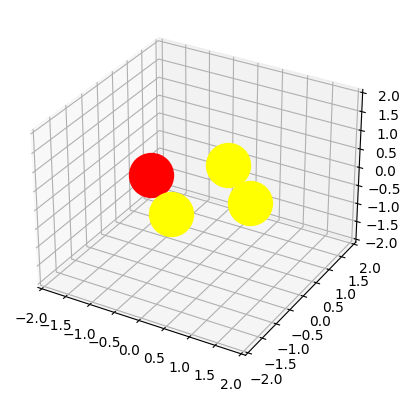

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

directions = ['North', 'South', 'East', 'West']
colors = {0: 'red', 1: 'yellow', 2: 'green'}
positions = [(1, 0, 0), (-1, 0, 0), (0, 1, 0), (0, -1, 0)]  # Assume these are the positions of the signals

# Create initial scatter plot
scatters = [ax.scatter(*positions[i], c='red', s=1000) for i in range(4)]

ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
ax.set_zlim(-2, 2)

def update(i):
    # Update the colors of each signal based on the prediction at the current second
    for j, scat in enumerate(scatters):
        scat.set_color(colors[preds[i, j]])

ani = FuncAnimation(fig, update, frames=range(0, len(preds), 600), interval=100)
HTML(ani.to_jshtml())
